In [3]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [1]:
def format_model_name(key):
    if key == 'rnn_dynamiclr':
        return 'RNN with Dynamic LR'
    elif key == 'rnn_fixedlr':
        return 'RNN with Fixed LR'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

## Plot loss for one-hot features

In [32]:
experiment_dir = "../trained_models/03_td_baselines/onehot/"
steps = []
losses = []
models = []

for model in os.listdir(experiment_dir):
    model_dir = experiment_dir + model + '/'
    try:
        model_name = format_model_name(model)
    except:
        continue # Not a directory we care about
    for _iter in os.listdir(model_dir):
        iter_dir = model_dir + _iter + '/'
        for file in os.listdir(iter_dir):
            if 'tfevents' not in file: continue
            tfevents_file = iter_dir + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            for i in range(len(scalar_events)):
                steps.append(scalar_events[i].step)
                losses.append(scalar_events[i].value)
                models.append(model_name)
            break

steps = np.array(steps)
losses = np.array(losses)
models = np.array(models)

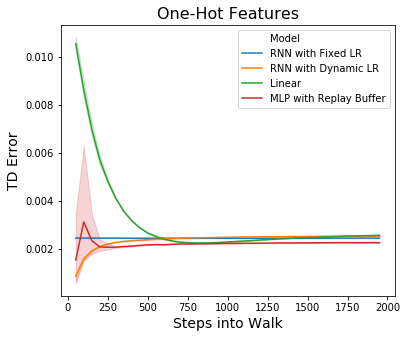

In [33]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({'Steps into Walk': steps, 'TD Error': losses, 'Model': models})
fig, ax = plt.subplots(figsize=(6.4*0.9, 4.8)) # width, height
sns.lineplot(x='Steps into Walk', y='TD Error', hue='Model', data=df, ax=ax)
plt.xlabel('Steps into Walk', fontsize=14)
plt.ylabel('TD Error', fontsize=14)
plt.title('One-Hot Features', fontsize=16)
plt.tight_layout()
plt.savefig('td_baseline_onehot.png', dpi=100)
plt.show()

## Plot loss for n-hot features

In [34]:
experiment_dir = "../trained_models/03_td_baselines/nhot/"
steps = []
losses = []
models = []

for model in os.listdir(experiment_dir):
    model_dir = experiment_dir + model + '/'
    try:
        model_name = format_model_name(model)
    except:
        continue # Not a directory we care about
    for _iter in os.listdir(model_dir):
        iter_dir = model_dir + _iter + '/'
        for file in os.listdir(iter_dir):
            if 'tfevents' not in file: continue
            tfevents_file = iter_dir + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            for i in range(len(scalar_events)):
                steps.append(scalar_events[i].step)
                losses.append(scalar_events[i].value)
                models.append(model_name)
            break

steps = np.array(steps)
losses = np.array(losses)
models = np.array(models)

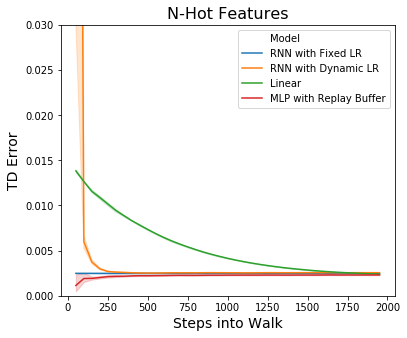

In [35]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({'Steps into Walk': steps, 'TD Error': losses, 'Model': models})
fig, ax = plt.subplots(figsize=(6.4*0.9, 4.8)) # width, height
sns.lineplot(x='Steps into Walk', y='TD Error', hue='Model', data=df, ax=ax)
plt.xlabel('Steps into Walk', fontsize=14)
plt.ylabel('TD Error', fontsize=14)
plt.title('N-Hot Features', fontsize=16)
plt.ylim(0, 0.03)
plt.tight_layout()
plt.savefig('td_baseline_nhot.png', dpi=100)
plt.show()